In [6]:
import os
import pandas as pd
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt

# set the path to the parent folder containing the 10 folders
directory="C:/Users/c0070810/OneDrive - Newcastle University/sim1"
#files = glob.glob("*.pkl")
#files.sort(key=os.path.getmtime)
#print("\n".join(files))

In [7]:

BODp = 0.7
CODp = 0.75
rainmax = []
c= []
iteration_count = 0

In [8]:
#Goes through all the folders
for folder_name in os.listdir(directory):
    folder_path = os.path.join(directory, folder_name)
    
    # check if the folder has files
    if os.path.isdir(folder_path) and os.listdir(folder_path):
        
        #goes through the files
        for filename in os.listdir(folder_path):
            if filename.endswith(".pkl"):
                iteration_count += 1 
                print(f"Iteration {iteration_count}: Processing file {filename}")
                
                try:
                    #open pkl
                    with open(os.path.join(folder_path, filename), "rb") as f:
                        df = pickle.load(f)

                    # rainfall
                    rainfall_max = df.get('rainfall72', []).max()
                    rainmax.append(rainfall_max)

                    #Normalization of the compliance threshold
                    BODut = (50 - df["bod31"].min()) / (df["bod1"].max() - df["bod31"].min())
                    CODut = (250 - df["cod31"].min()) / (df["cod1"].max() - df["cod31"].min())
                    BODlt = (25 - df["bod31"].min()) / (df["bod1"].max() - df["bod31"].min())
                    CODlt = (125 - df["cod31"].min()) / (df["cod1"].max() - df["cod31"].min())

                    #normalization of the inputs and outputs (BODe, CODe, BODi, CODi)
                    df["LIN_BODe"] = (df["bod31"] - df["bod31"].min()) / (df["bod1"].max() - df["bod31"].min())
                    df["LIN_CODe"] = (df["cod31"] - df["cod31"].min()) / (df["cod1"].max() - df["cod31"].min())
                    df["LIN_BODi"] = (df["bod1"] - df["bod31"].min()) / (df["bod1"].max() - df["bod31"].min())
                    df["LIN_CODi"] = (df["cod1"] - df["cod31"].min()) / (df["cod1"].max() - df["cod31"].min())

                    # Compute the c calc
                    UTb = BODut - df["LIN_BODe"]
                    UTc = CODut - df["LIN_CODe"]
                    LTb = BODlt - df["LIN_BODe"]
                    LTc = CODlt - df["LIN_CODe"]
                    pb = -(BODp * df["LIN_BODi"]) + df["LIN_BODi"] - df["LIN_BODe"]
                    pc= -(CODp * df["LIN_CODi"]) + df["LIN_CODi"] - df["LIN_CODe"]

                    max1 = np.maximum(LTb, pb)
                    max2= np.maximum(LTc, pc )
                    
                    # Compute 'c_BOD' and 'c_COD'
                    df["c_BOD"] = np.minimum(UTb, max1)
                    df["c_COD"] = np.minimum(UTc, max2)
                    
                    # Compute 'ci' for each simulation
                    df["ci"] = df[["c_BOD", "c_COD"]].min(axis=1)
                    
                    # Back-calculate 'BOD_C_BACK' and 'COD_C_BACK' for each simulation
                    #df["BOD_C_BACK"] = df["c_BOD"] * (df["bod1"].max() - df["bod31"].min()) + df["bod31"].min()
                    #df["COD_C_BACK"] = df["c_COD"] * (df["cod1"].max() - df["cod31"].min()) + df["cod31"].min()
                    #df["MIN_C_BACK"]=df["MIN_C_BACK"] = df[['BOD_C_BACK','COD_C_BACK']].min(axis=1)

                    # Adding the values to 'c' e 'c_back'
                    c.append(df["ci"].min())
                    #c_back.append(df["MIN_C_BACK"].min())


                except Exception as e:
                    print(f"Error processing file {filename}: {e}")




Iteration 1: Processing file profile_run_1.pkl
Iteration 2: Processing file profile_run_10.pkl
Iteration 3: Processing file profile_run_11.pkl
Iteration 4: Processing file profile_run_12.pkl
Iteration 5: Processing file profile_run_13.pkl
Iteration 6: Processing file profile_run_14.pkl
Iteration 7: Processing file profile_run_15.pkl
Iteration 8: Processing file profile_run_16.pkl
Iteration 9: Processing file profile_run_17.pkl
Iteration 10: Processing file profile_run_18.pkl
Iteration 11: Processing file profile_run_19.pkl
Iteration 12: Processing file profile_run_2.pkl
Iteration 13: Processing file profile_run_20.pkl
Iteration 14: Processing file profile_run_21.pkl
Iteration 15: Processing file profile_run_22.pkl
Iteration 16: Processing file profile_run_23.pkl
Iteration 17: Processing file profile_run_24.pkl
Iteration 18: Processing file profile_run_25.pkl
Iteration 19: Processing file profile_run_26.pkl
Iteration 20: Processing file profile_run_27.pkl
Iteration 21: Processing file p

In [ ]:
# Create empty lists to store average BOD31 and COD31 values per run
average_bod31_per_run = []
average_cod31_per_run = []

# Iterate through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a pickle file
    if filename.endswith(".pkl"):
        # Construct the full path to the file
        file_path = os.path.join(directory, filename)
        # Read the pickle file
        dataframes[filename] = pd.read_pickle(file_path)
        data = dataframes[filename].copy()  # Retrieve DataFrame from dictionary
        
        # Calculate average BOD31 and COD31 for this run
        average_bod31 = data.bod31.mean()
        average_cod31 = data.cod31.mean()
        
        # Append the averages to the respective lists
        average_bod31_per_run.append(average_bod31)
        average_cod31_per_run.append(average_cod31)


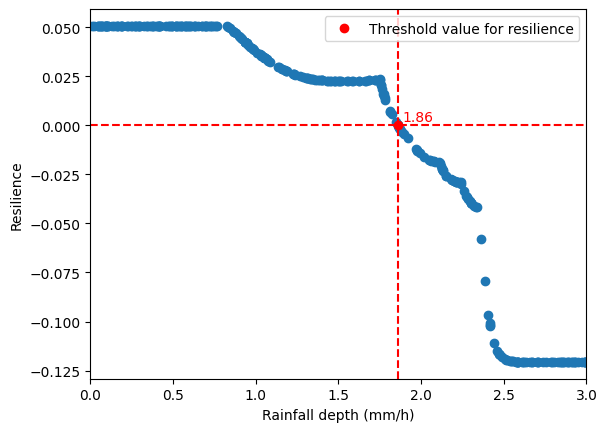

In [10]:
# Find the index of the point closest to 0 in the c_back array
idx_closest_to_zero = np.abs(c).argmin()

# Get the corresponding x and y values
x_closest_to_zero = rainmax[idx_closest_to_zero]
y_closest_to_zero = c[idx_closest_to_zero]

# Plot your scatter plot
plt.scatter(rainmax, c)
plt.xlim(0, 3)
plt.xlabel("Rainfall depth (mm/h)")
plt.ylabel("Resilience")

# Plot horizontal and vertical lines
plt.axhline(y=y_closest_to_zero, color='r', linestyle='--')
plt.axvline(x=x_closest_to_zero, color='r', linestyle='--')

# Plot a point at the intersection
plt.plot(x_closest_to_zero, y_closest_to_zero, 'o', color='r', label='Threshold value for resilience')

# Customize annotation position
x_annotation = 1.98
y_annotation = 0.002
plt.annotate(f'{x_closest_to_zero:.2f}', (x_closest_to_zero, 0), xytext=(x_annotation, y_annotation),
             ha='center', color='r')
plt.legend(loc="upper right")
plt.savefig('resilience.png', dpi=1200)
plt.show()

